# Hydra Neuomechanical Modeling

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os, multiprocessing
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import h5py

from hydra.model.smc import SMC
from hydra.model.force_encoder_ecto import ForceEncoderEcto
from hydra.model.force_encoder_endo import ForceEncoderEndo
from hydra.model.fluo_encoder import FluoEncoder
from hydra.model import plot
import hydra.model.helper as helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single-Cell Dynamics

In [3]:
# Define single-cell model
model = SMC(T=500, 
            dt=0.0002, 
            k_ipr=0.02, 
            s0=100, 
            d=20e-4, 
            v_delta=0.03)

100%|██████████| 10000/10000 [00:00<00:00, 20371.55it/s]


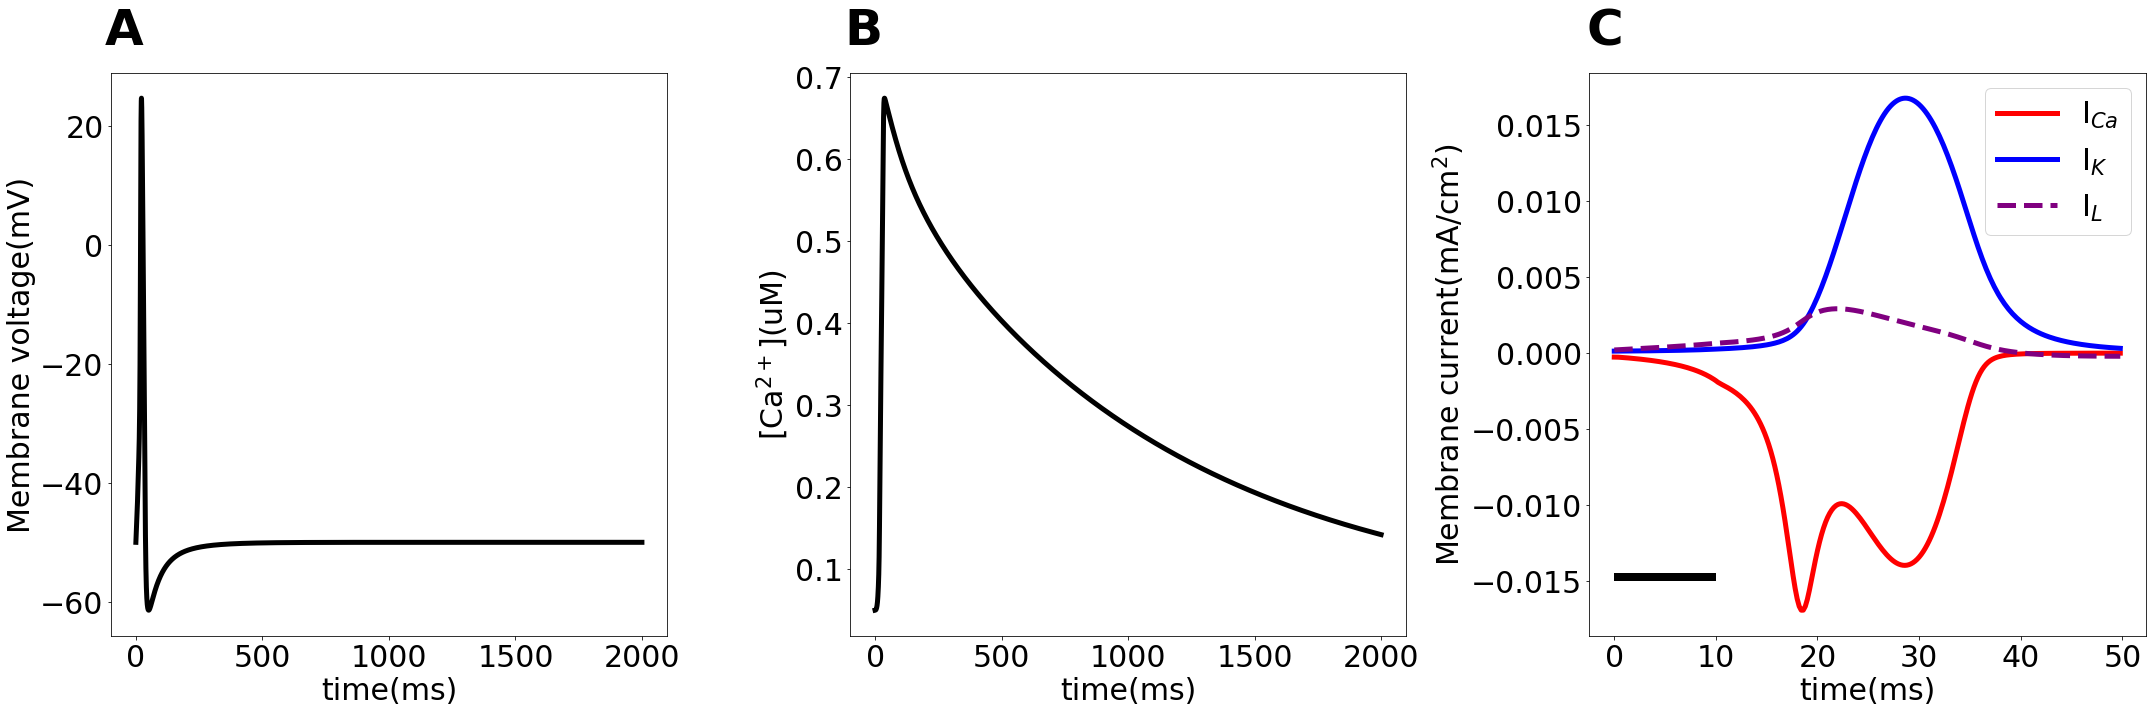

In [4]:
# Plot results of one fast spike
sol = model.run(stims_fast = [0], 
                stims_slow = [-100],
                T=2,
                dt=0.0002)
plot.plot_single_spike(model, sol, 0, 2, 0, 0.05, full_cell=True, save_fig=True, save_path="./results/figures/fast-pathway.png")

100%|██████████| 500000/500000 [00:24<00:00, 20802.16it/s]


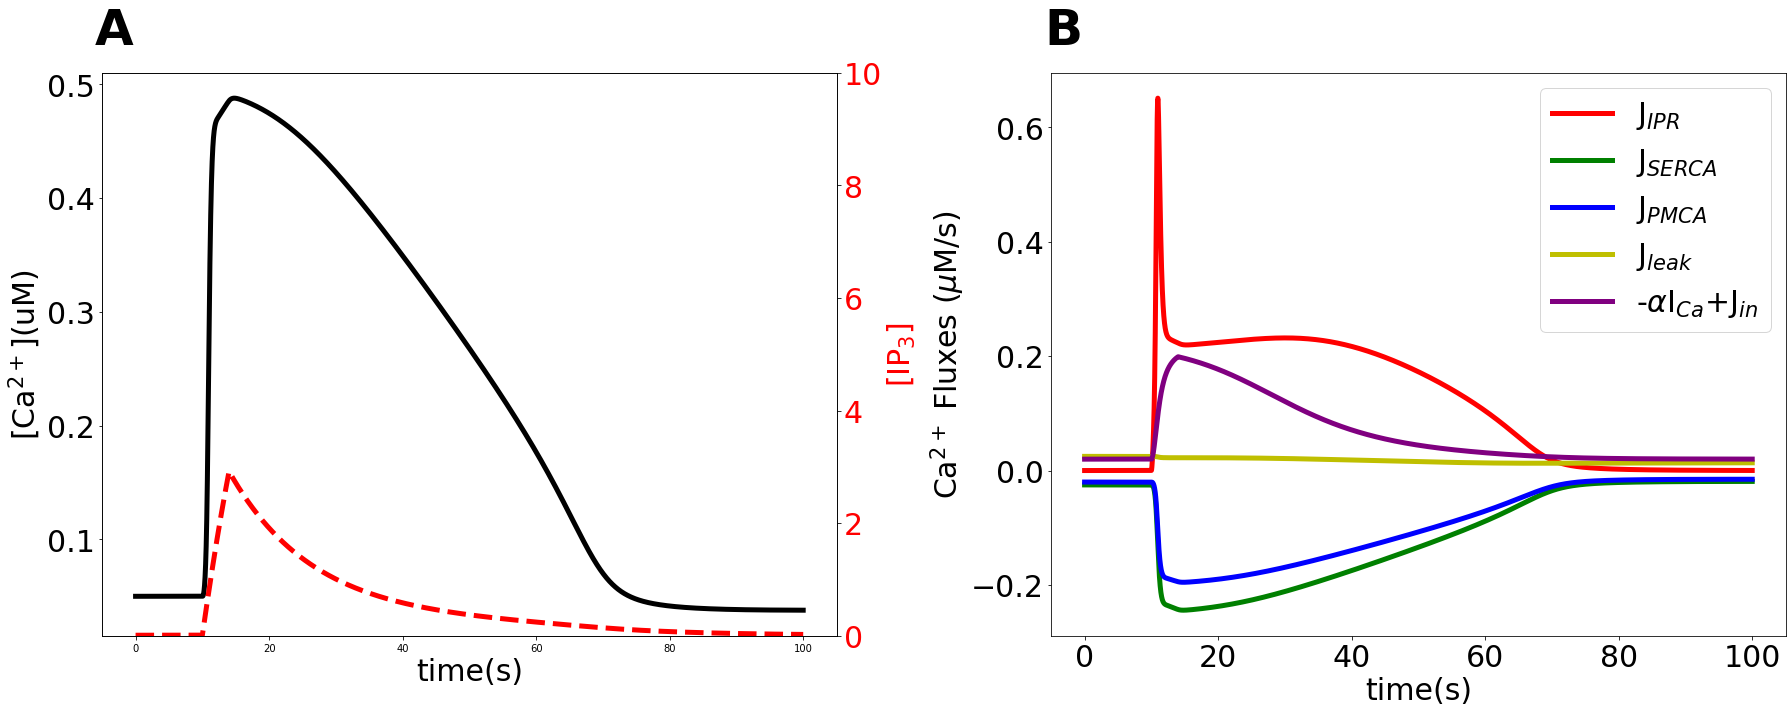

In [5]:
# Plot results of one slow transient
sol = model.run(stims_fast = [-100], 
                stims_slow = [10],
                T=100,
                dt=0.0002)
plot.plot_slow_transient(model, sol, 0, 100, full_cell=True, save_fig=True, save_path="./results/figures/slow-pathway.png")

In [5]:
# Plot multiple fast spikes
sol = model.run(stims_fast=[0, 4.4, 7.1, 9.3, 11.2, 13.2, 15.7, 18.4, 21.2, 24.7,
                            100, 105.2, 108.2, 110.6, 112.8, 115, 117.3, 119.4, 121.9, 125.1, 129.5, 134.3,
                            200, 205.7, 208.8, 211.6, 213.8, 216.1, 218.3, 221, 224.2, 229, 235.4], 
                stims_slow=[-100])

100%|██████████| 2500000/2500000 [02:15<00:00, 18476.95it/s]


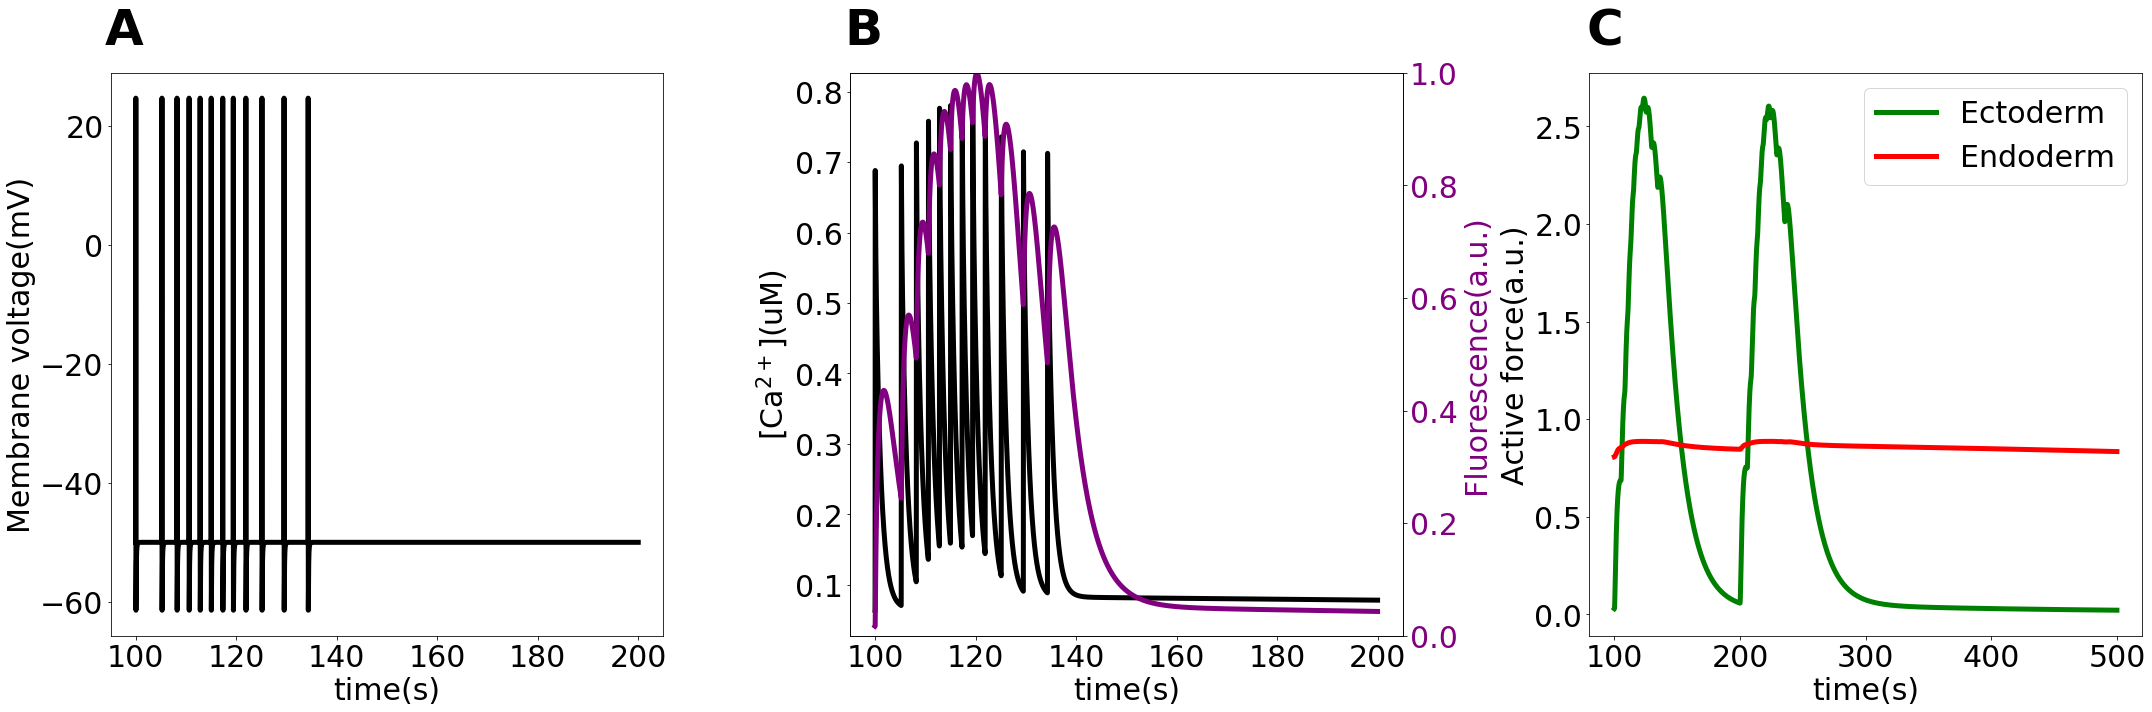

In [6]:
force_ecto = ForceEncoderEcto.encode(sol[:, 0], model.dt);
force_endo = ForceEncoderEndo.encode(sol[:, 0], model.dt);
plot.plot_multiple_spikes(model, sol, force_ecto, force_endo, 100, 200, 100, 500, save_fig=True, save_path="./results/figures/multiple-fast.png")

In [8]:
# Save the single-cell force data
force_ecto_intp = force_ecto[::50]
force_endo_intp = force_endo[::50]
time_intp = np.arange(0, 500, 0.01)

force_ecto_data = pd.DataFrame(np.array([time_intp, force_ecto_intp]).T)
force_endo_data = pd.DataFrame(np.array([time_intp, force_endo_intp]).T)

force_ecto_data.to_csv("./results/data/force/force_ecto_single.txt", index=False, header=False)
force_endo_data.to_csv("./results/data/force/force_endo_single.txt", index=False, header=False)

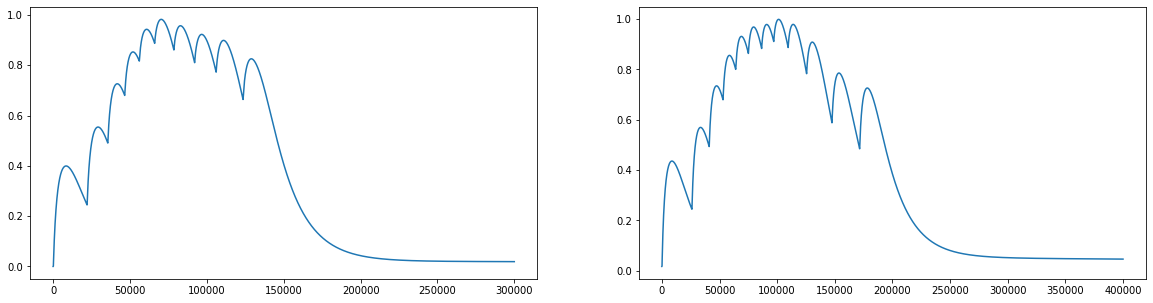

In [14]:
# Plot the encoded fluorescence of the two CBs
c = sol[:, 0]
v = sol[:, 4]
fluo_encoder = FluoEncoder(c, T=model.T, dt=model.dt)
fluo = fluo_encoder.step()
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot((fluo[0:300000]-min(fluo))/(max(fluo)-min(fluo)))
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot((fluo[500000:900000]-min(fluo))/(max(fluo)-min(fluo)))
plt.show()

## Multicellular Dynamics

In [2]:
# Run the model ()
# !bash manager.sh

In [47]:
FILENAME = "2020-04-22-02-23-11-903528"

# Load metadata
data = pd.read_csv("~/Documents/hydra/hydra/results/data/meta.txt", sep="\s+")
print(data.Metadata[data.Filename == FILENAME].values[0])

numx=200,numy=200,T=100,dt=0.0002,k_ipr=0.04,s0=100.0,d=0.002,v_delta=0.03,fast


In [48]:
# Read the simulation results
calcium = pd.read_hdf("./results/data/calcium/" + FILENAME + ".h5")
calcium = calcium.values.reshape(len(calcium), 200, 200)

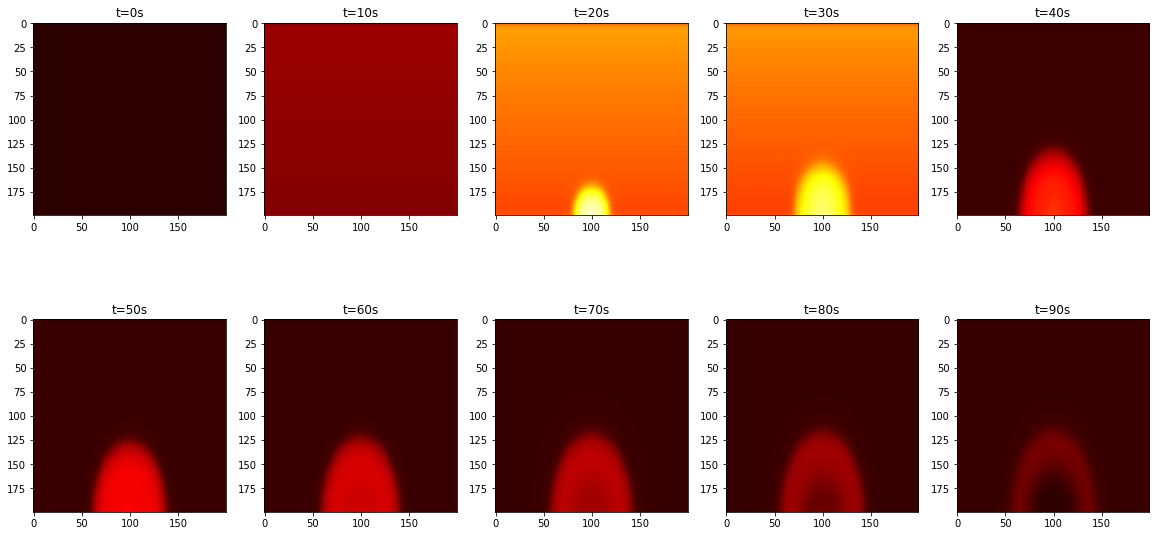

In [4]:
# Plot calcium patterns at specified times
plot.plot_frame_patterns(calcium, list(range(0, 100, 10)), vmin=0, vmax=1, dt=0.02)

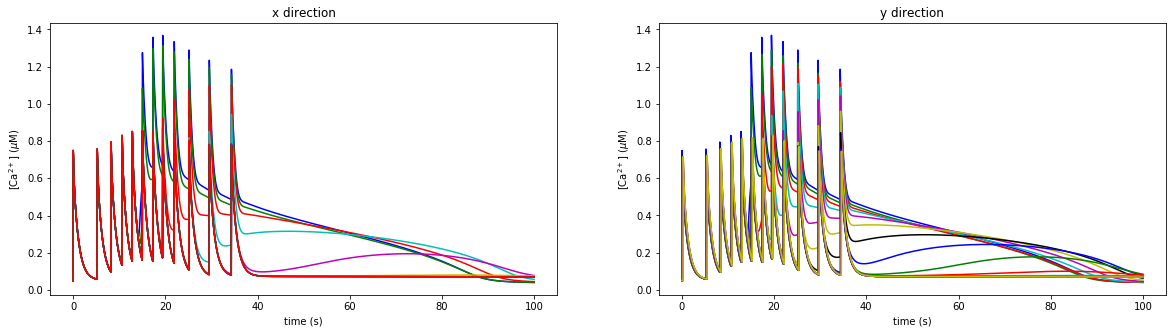

In [5]:
# Plot the calcium traces in different directions
plot.plot_1d_traces(calcium, 10, 0.02)

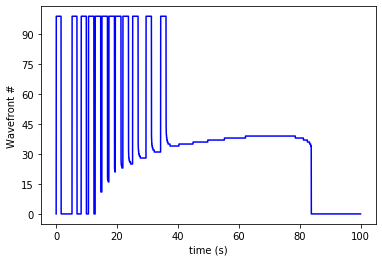

In [6]:
# Track the wavefront 
timeline = np.linspace(0, 100, int(100/0.02))
wavefront = helper.track_wavefront(calcium[:, 100:200, 0], 0.2)
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(timeline, wavefront)
ax.set_xlabel("time (s)")
ax.set_ylabel("Wavefront #")
plt.show()

In [49]:
# Encode the calium into force
force = helper.encode_force_2d(ForceEncoderEndo, calcium, 200, 200, 0.02)

100%|██████████| 5000/5000 [00:32<00:00, 154.18it/s]


In [50]:
# Average the force and save
force_averaged = helper.average_force(force, 200, 200)
df = pd.DataFrame(force_averaged.reshape(-1, 400))
df.to_csv("./results/data/force/" + FILENAME + ".csv", index = False)
del force